In [1]:
import tensorflow

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from skimage.io import imread, imshow
from skimage.transform import resize


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10


In [5]:
path = 'C:/Users/PREETHAM/cranial hemm/'
os.listdir(path)

['.ipynb_checkpoints',
 'bone_image_dir',
 'brain_image_dir',
 'Colab_Notebook_Intracranial_Hemorrhage_Analyzer.ipynb',
 'computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0',
 'df_data.csv.gz',
 'df_test.csv.gz',
 'df_train.csv.gz',
 'df_val.csv.gz',
 'mask_dir',
 'Untitled.ipynb']

In [6]:
# This is how to access the downloaded folders

base_path = "computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/"

os.listdir(base_path)

['ct_ich.yml',
 'hemorrhage_diagnosis.csv',
 'LICENSE.txt',
 'Patients_CT',
 'patient_demographics.csv',
 'README.txt',
 'SHA256SUMS.txt',
 'split_data.py']

In [7]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix


In [8]:
%%capture

! pip install segmentation-models

In [9]:
path = base_path + 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(path)

# The existing No_Hemorrhage target column is not intuitive. 
# Create a new target column to make the binary targets easier to understand.

def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49            1                 0                 0   
1             49            2                 0                 0   
2             49            3                 0                 0   
3             49            4                 0                 0   
4             49            5                 0                 0   

   Subarachnoid  Epidural  Subdural  Fracture_Yes_No  Has_Hemorrhage  
0             0         0         0                0               0  
1             0         0         0                0               0  
2             0         0         0                0               0  
3             0         0         0                0               0  
4             0         0         0                0               0

In [10]:
# Patient 84
# Brain image 36.jpg exists but bone image 36.jpg is missing.

# Therefore, we will drop this row from the dataframe.

index_to_drop = df_diag[(df_diag['PatientNumber'] == 84) & (df_diag['SliceNumber'] == 36)].index

index_to_drop = index_to_drop[0]

df_diag = df_diag.drop(index_to_drop, axis=0)


# Check that the row that we dropped has been removed
df_diag[df_diag.index == index_to_drop]

Empty DataFrame
Columns: [PatientNumber, SliceNumber, Intraventricular, Intraparenchymal, Subarachnoid, Epidural, Subdural, Fracture_Yes_No, Has_Hemorrhage]
Index: []

In [11]:
# Create new columns


def get_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    


# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)


def new_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)


def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname

# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    


# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)


df_diag.head()

PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49            1                 0                 0   
1             49            2                 0                 0   
2             49            3                 0                 0   
3             49            4                 0                 0   
4             49            5                 0                 0   

   Subarachnoid  Epidural  Subdural  Fracture_Yes_No  Has_Hemorrhage  \
0             0         0         0                0               0   
1             0         0         0                0               0   
2             0         0         0                0               0   
3             0         0         0                0               0   
4             0         0         0                0               0   

      mask_fname    new_mask_fname image_fname new_image_fname  
0  1_HGE_Seg.jpg  49_1_HGE_Seg.jpg       1.jpg        49_1.jpg  
1  2_HGE_Seg.jpg  49_2_HGE_Seg.jpg       2.jpg        49_2.jpg  
2  3_HGE_Seg.jpg  49_3_HGE_Seg.jpg       3.jpg        49_3.jpg  
3  4_HGE_Seg.jpg  49_4_HGE_Seg.jpg       4.jpg        49_4.jpg  
4  5_HGE_Seg.jpg  49_5_HGE_Seg.jpg       5.jpg        49_5.jpg

In [12]:
path = base_path + 'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [13]:
# create a new mask dir
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'mask_dir'

In [14]:
# For non blank masks

for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 1]
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # Source path to mask.
        # All masks are in the brain folder.
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(mask_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
 
# Check how many masks are in the new folder. (Should be 318)
len(os.listdir('mask_dir'))

2500

In [15]:
# For blank masks

blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 0]  # <-- for empty masks change filter here
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # set the destination where the file will be saved
        dst = os.path.join(mask_dir, new_fname)
      
        # save the image
        cv2.imwrite(dst, blank_mask)
        
 
# Check how many masks are in the new folder. (Should be 2500)
len(os.listdir('mask_dir'))



2500

In [16]:
# create a new mask dir
brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'brain_image_dir'

In [17]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(brain_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        

# Check how many images are in the new folder (Should be 2500)
len(os.listdir('brain_image_dir'))

2500

In [18]:
# create a new mask dir
bone_image_dir = 'bone_image_dir'
os.mkdir(bone_image_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'bone_image_dir'

In [19]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/bone'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(bone_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        
# Check how many images are in the new folder (Should be 2500)
len(os.listdir('bone_image_dir'))

2500

(650, 650)


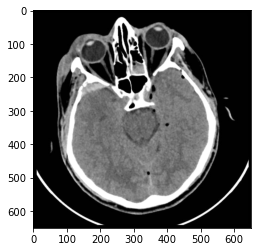

In [20]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = plt.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


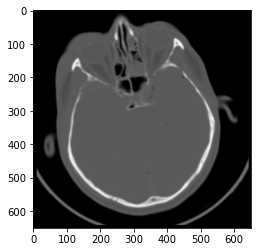

In [21]:
# bone image

fname = df_diag.loc[index, 'new_image_fname']
path = 'bone_image_dir/' + fname
# read the image as a matrix
bone_image = plt.imread(path)

print(bone_image.shape)

plt.imshow(bone_image, cmap='gray')

(650, 650)


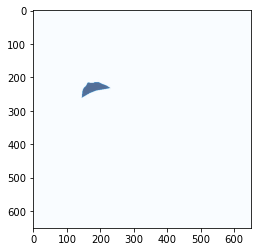

In [22]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

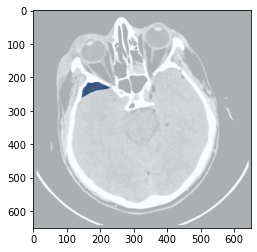

In [23]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

In [24]:
# HOW TO DO MULTIPLE AUGMENTATIONS

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


# This how to call the function
# aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)

C:\Users\PREETHAM\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\PREETHAM\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(650, 650, 3)


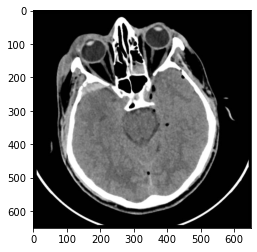

In [25]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = cv2.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


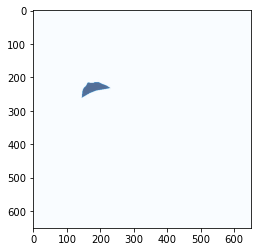

In [26]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

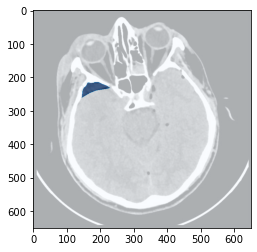

In [27]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

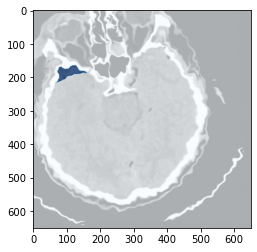

In [28]:
# Example augmentation - image and mask

# augment the image and mask
aug_image, aug_mask = augment_image_and_mask(aug_types, brain_image, mask)



plt.imshow(aug_image, cmap='gray')
plt.imshow(aug_mask, cmap='Blues', alpha=0.7)

In [29]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_image_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
   
  
  
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

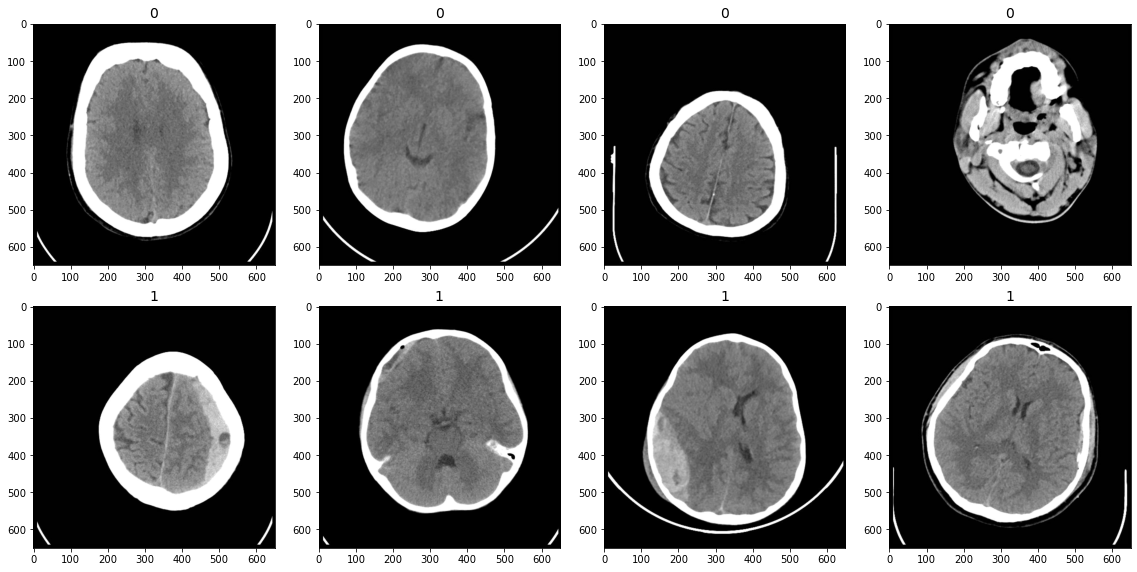

In [30]:
# Brain images

IMAGE_PATH = 'brain_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

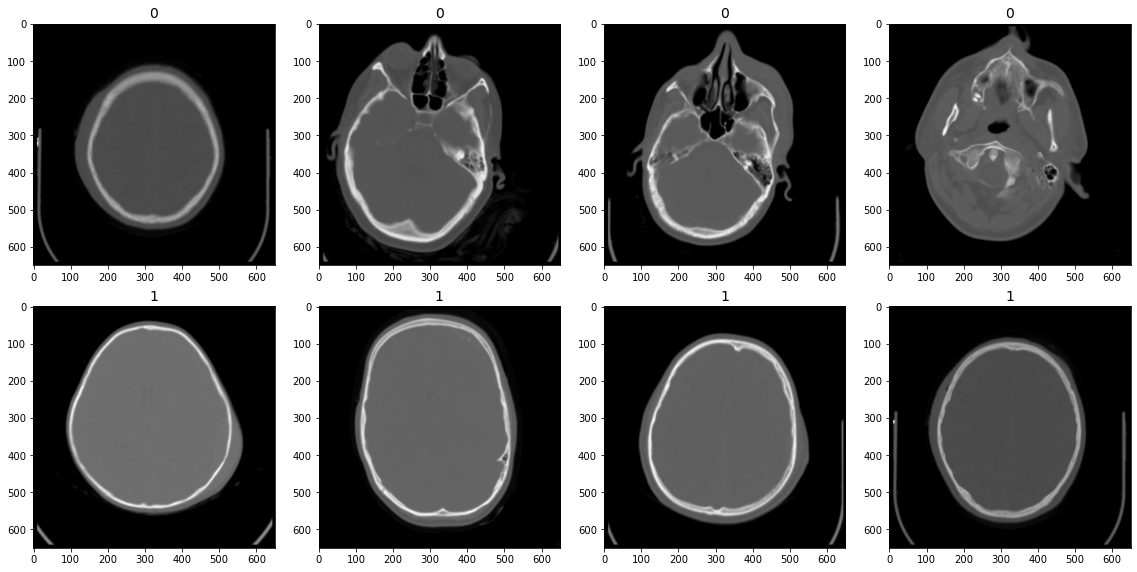

In [31]:
# Bone images

IMAGE_PATH = 'bone_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

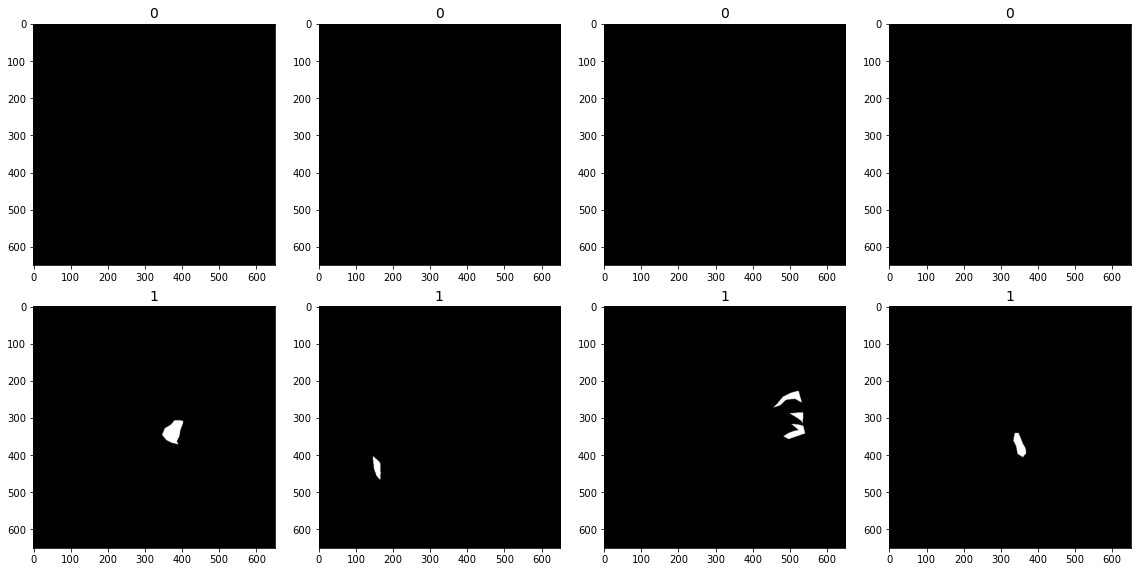

In [32]:
# Masks

IMAGE_PATH = 'mask_dir/'

draw_category_masks('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

In [33]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2480, 13)
(20, 13)


In [34]:
df_test.head()

PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49           20                 0                 0   
1             50           26                 0                 1   
2             81           16                 0                 0   
3             49           27                 0                 1   
4             70           13                 0                 0   

   Subarachnoid  Epidural  Subdural  Fracture_Yes_No  Has_Hemorrhage  \
0             0         1         0                1               1   
1             0         0         0                1               1   
2             0         0         1                0               1   
3             0         0         0                1               1   
4             0         1         0                0               1   

       mask_fname     new_mask_fname image_fname new_image_fname  
0  20_HGE_Seg.jpg  49_20_HGE_Seg.jpg      20.jpg       49_20.jpg  
1  26_HGE_Seg.jpg  50_26_HGE_Seg.jpg      26.jpg       50_26.jpg  
2  16_HGE_Seg.jpg  81_16_HGE_Seg.jpg      16.jpg       81_16.jpg  
3  27_HGE_Seg.jpg  49_27_HGE_Seg.jpg      27.jpg       49_27.jpg  
4  13_HGE_Seg.jpg  70_13_HGE_Seg.jpg      13.jpg       70_13.jpg

In [35]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(372, 13)


In [36]:
df_train['Has_Hemorrhage'].value_counts()

0    1846
1     262
Name: Has_Hemorrhage, dtype: int64

In [37]:
df_val['Has_Hemorrhage'].value_counts()

0    326
1     46
Name: Has_Hemorrhage, dtype: int64

In [38]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)


In [ ]:
pip install keras tensorflow